# Validation Kernel

We should have done this as our first step, but better late than never. This simple kernel demonstrates how to run local feature validation.

In [1]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc, warnings, json
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [3]:
# For each categorical variable, we'd like to experiment with
# the count of appearances within that day's hour
# This will only work if the distributions (counts) are similar in train + test

START_DATE     = '2017-11-01'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['thour']  = traintr.tdt.dt.hour
traintr['tmonth'] = (traintr.tdt.dt.year-2017) * 12 + traintr.tdt.dt.month
traintr['tweek'] = 52 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.weekofyear
traintr['tdoy'] = 365 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.dayofyear
traintr.tdoy -= traintr.tdoy.min() # 0-offset

testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['thour']  = testtr.tdt.dt.hour
testtr['tmonth'] = (testtr.tdt.dt.year-2017) * 12 + testtr.tdt.dt.month
testtr['tweek'] = 52 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.weekofyear
testtr['tdoy'] = 365 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.dayofyear
testtr.tdoy -= traintr.tdoy.min() # 0-offset

traintr.tdt.min()

Timestamp('2017-11-02 00:00:00')

In [4]:
traintr.groupby('tmonth').size()

tmonth
11    130968
12     92770
13     96196
14     90667
15     87512
16     86934
17      5493
dtype: int64

In [5]:
traintr.tdoy.min(),traintr.tdoy.max()

(0, 181)

# Feature Evaluation Pipeline

In [6]:
SEED = 2**8+1

# TODO: Optimize
lgb_params = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'learning_rate':0.01,
    'num_leaves': 2**5, # 5-8
    'max_depth':-1,
    'tree_learner':'serial',
    'colsample_bytree': 0.7, ######################
    'subsample':0.7, ####################    
    
    'subsample_freq':1,

    'max_bin':255,
    'verbose':-1,
    'seed': SEED,
    'feature_fraction_seed': SEED + 2,
    'bagging_seed': SEED + 3,
    'drop_seed': SEED + 4,
    'data_random_seed': SEED + 5,
} 

In [7]:
def display_report(report):
    print('{} Folds Used'.format(len(report['folds'])))
    print('{} Neg DownSample Frac with {} Seed'.format(report['downsample_frac'], report['downsample_seed']))
    print('{} AVG AUC, {} STD'.format(np.round(report['avg_auc'],3), np.round(report['std_auc'],3)))
    print('{} AVG Train AUC, {} STD'.format(np.round(report['avg_train_auc'],3), np.round(report['std_train_auc'],3)))
    print(np.abs(np.round(report['avg_train_auc'] - report['avg_auc'],3)), 'Train-Val AUC Drift')
    print('{} AVG Rounds, {} STD'.format(report['avg_iterations'], report['std_iterations']), end='\n\n')

    features = pd.DataFrame({
        'feature': report['features'],
        'adversarial': list(report['cvs'].values()),
        'perm_import': list(report['avg_permutation_importance'].values()),
        'perm_import_std': list(report['std_permutation_importance'].values()),
    })
    #if do_cvs
    features.sort_values(['perm_import','adversarial'], ascending=False, inplace=True)
    
    sns_df = pd.DataFrame({
        'feature' : sum([list(fold['permutation_importance'].keys()) for fold in results['folds']], []),
        'perm_import': sum([list(fold['permutation_importance'].values()) for fold in results['folds']], []),
        
    })
    sns_df.sort_values(['feature','perm_import'], ascending=False, inplace=True)
    
    print(report['params'])
    return features, sns_df

def compare_reports(report1, report2):
    pass

In [8]:
def run_evaluation(data, features, params, do_cvs=True, downsample_seed=None, downsample_frac=0.2, save_file_path=None):
    # NOTE: data should contain, at minimal, all train + test samples,
    # along with the isFraud column, for separation and scoring purposes.
    gc.collect()
    
    # Run evaluation and store results in a report
    # Steps:
    # 1) [x] Negative Downsample non-frauds
    # 2) [x] Run adversarial validation on features + record scores
    # 3) [x] Train on 50% overlapping folds on the trainset
    # 3b) [x] Perform permutation importance (soon to be drop importance) each fold
    # 4) [x] Aggregate and save results
    
    report = {
        'features': features,
        'params': params,
        'downsample_seed': downsample_seed,
        'downsample_frac': downsample_frac,
        'cvs': {},
        'folds': [],
        'avg_permutation_importance': {},
        'std_permutation_importance': {},
    }
    
    ######################
    print('\n# 1) [x] Negative Downsample (non-frauds)')
    if downsample_seed is None:
        selection = data.copy()
    else:
        np.random.seed(downsample_seed)
        normies = data[data.isFraud==0].index.values
        normies = np.random.choice(
            normies,
            int(data.shape[0]*downsample_frac),
            replace=False
        )
        selection = data[data.index.isin(
            # All fruds and a number of normies
            np.concatenate([normies, data[data.isFraud==1].index.values])
        )].copy()
    print(selection.shape[0], 'total train samples!')
    
    if selection.shape[0] > data.isFraud.isna().sum():
        # If we have more train samples than test samples, use all test samples
        selection_test = data[data.isFraud.isna()]
    else:
        # Use a balanced set of test samples 
        selection_test = np.random.choice(
            data[data.isFraud.isna()].index.values,
            selection.shape[0],
            replace=False
        )
        selection_test = data[data.index.isin(selection_test)]

    ######################
    if do_cvs:
        print('\n# 2) [x] Run adversarial validation (CVS) on features + record scores')
        # Build CVS dataset
        cvsdata = selection.append(selection_test, sort=False)
        cvsdata.reset_index(inplace=True)
        cvsdata['which_set'] = (np.arange(cvsdata.shape[0]) >= selection.shape[0]).astype(np.uint8)
        cvsdata = cvsdata.sample(frac=1).reset_index(drop=True) # Shuffle the thing
        trn_cvs = cvsdata.index < (cvsdata.shape[0] // 2)
        for col in features:
            trn_lgb = lgb.Dataset(cvsdata[trn_cvs][[col]], label=cvsdata[trn_cvs].which_set)
            val_lgb = lgb.Dataset(cvsdata[~trn_cvs][[col]], label=cvsdata[~trn_cvs].which_set)
            clf = lgb.train(
                params,
                trn_lgb,
                valid_sets = [trn_lgb, val_lgb],
                verbose_eval = 200,
                early_stopping_rounds = 25,
                num_boost_round = 80000,
            )
            report['cvs'][col] = clf.best_score['valid_1']['auc'] - 0.5 # 0.5 = 0, best score
        del cvsdata, trn_lgb, val_lgb, trn_cvs; gc.collect()
    
    ######################
    print('\n#3) [x] Train on 50% overlapping folds on the trainset')
    for fold_, i in enumerate(range(0,57,14)):
        gc.collect()
        fold = {
            'fold_num': fold_,
            'trn_range': [i,i+90],
            'val_range': [i+90+15,i+90+15+20],
        }
        print('\nFold', fold_+1, '— Train', fold['trn_range'], '— Test', fold['val_range'])
        
        trn = selection[selection.tdoy.between(i, 90+i)]
        val = selection[selection.tdoy.between(90+i+15, 90+i+15+20)].copy()
        trn_lgb = lgb.Dataset(trn[features], label=trn.isFraud)
        val_lgb = lgb.Dataset(val[features], label=val.isFraud)
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 25,
            num_boost_round = 80000,
            #categorical_feature=[]
        )
        baseline = clf.best_score['valid_1']['auc']
        fold['auc'] = baseline
        fold['train_auc'] = clf.best_score['training']['auc']
        fold['iterations'] = clf.best_iteration
        print('baseline - ', baseline)
        
        ######################
        # TODO: Repalce with Drop importance
        print('\n#3b) [x] Perform permutation importance (soon to be drop importance) each fold')
        perm = {}
        for col in features:
            backup = val[col].values.copy()
            val[col] = np.random.permutation(val[col].values)
            
            y_true = clf.predict(val[features])
            perm[col] = baseline - roc_auc_score(val.isFraud, y_true)
            val[col] = backup
        fold['permutation_importance'] = perm
        report['folds'].append(fold)
    
    ######################
    print('\n# 4) [x] Aggregate and save results')
    aucs = [fold['auc'] for fold in report['folds']]
    report['avg_auc'] = np.mean(aucs)
    report['std_auc'] = np.std(aucs)
    
    aucs = [fold['train_auc'] for fold in report['folds']]
    report['avg_train_auc'] = np.mean(aucs)
    report['std_train_auc'] = np.std(aucs)

    iterations = [fold['iterations'] for fold in report['folds']]
    report['avg_iterations'] = np.mean(iterations)
    report['std_iterations'] = np.std(iterations)

    for feature in features:
        pi = [fold['permutation_importance'][feature] for fold in report['folds']]
        report['avg_permutation_importance'][feature] = np.mean(pi)
        report['std_permutation_importance'][feature] = np.std(pi)

    if save_file_path is not None:
        with open(save_file_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=4)
    
    gc.collect()
    return report

The function above does a few things. First, it downsamples the negative values. This was reported by a number of top-50 people on the forums, and gold medal winners in previous competitions have used this technique as well. The idea being that fraud is unique and it shouldn't matter much which non-frauds we train against, since the frauds are a distinct class and should have some level of 'difference' about them. Think outliers. This would also be a good time to mention that when we train for _submission_, we can add diversity to our models by emsembling various batches trained with different samples non-fraud values =).

The next thing the method above does is compute covariate shift scores per feature, e.g. adversarial validation. The smaller the number, the more ideal the variable. The larger the value, the worse it is—the easier it is for our model to tell train samples from test samples. If there is too much shift, we can expect our model to fail at generalizing in the private lb. We should shoot for features that have <= 0.02 CVS. If you have a really good (high permutation importance auc, low permutation importance std) feature that also has a high CVS, try engineering, transforming, windsorizing, or otherwise degrading the variable until you get it within the cutoff threshold range.

Moving on, the method above trains various overlapping folds. The folds are 90 days long, have a 15 day gap, and then use the next 20 days for validation. These windows are shifted +14 days each fold, until we get to the end of the dataset. As-Is, it doesn't matter what start date you set, because each day will still have 24hours. But if you generate features that are like holiday features, then start date becomes important.

As each fold is trained, we calculate the permutation importance measure. There's a lot of talk about what that is so I won't go into it in detail here (https://explained.ai/rf-importance/ https://arxiv.org/abs/1706.03825). Just know that it's not perfect. It's 10000x better than the stalk-feature-importance measures; but to get the true feature importance, we need to run a drop importance calculation. I haven't added it here because it slows down the execution a bit (re-trains the model for each feature); but it'll probably be in our best interest to switch to that anyway.

Any feature that has a <0 permutation or drop importance should be discarded immediately. And any feature with a veri low importance, we can consider discarding recursively to test if it improves out model's score.

# Prepare Data

In [9]:
# Merge train + test
gc.collect()
data = traintr.append(testtr, sort=False)
data.reset_index(inplace=True)

In [10]:
# # Fill NA card data inasmuch as possible:
# fill_cols = ['card2','card3','card4','card5','card6']
# for col in fill_cols:
#     card12 = data[~data.card2.isna()][['card1',col]].groupby(['card1',col]).size().reset_index()

#     card12.rename(columns={0:'card1_cnt'}, inplace=True)
#     card12_cnts = card12[card12.card1_cnt>2].copy() # threshold of instances of pairings needed before we accept it
#     card12 = card12.groupby('card1').size().reset_index()
#     card12.rename(columns={0:col+'_cnt'}, inplace=True)
#     card12 = card12[card12[col+'_cnt']==1] # filter out any card where we see more than one card2 per card1
#     card12 = card12.merge(card12_cnts, how='inner', on='card1')[['card1',col]]

#     mapping = {card1:col_val for card1,col_val in card12.values}
#     nas = data[col].isna()
#     data.loc[nas, col] = data[nas].card1.map(mapping)
#     print('Filling', col, nas.sum(), 'initial nas.', data[col].isna().sum(), 'ending nas')

# Fill NA card data inasmuch as possible:
fill_cols = ['card2','card3','card4','card5','card6']
for col in fill_cols:
    # We use both ProductCD+card1
    card12 = data[~data.card2.isna()][['ProductCD','card1',col]].groupby(['ProductCD','card1',col]).size().reset_index()

    card12.rename(columns={0:'card1_cnt'}, inplace=True)
    card12_cnts = card12[card12.card1_cnt>=2].copy() # threshold of instances of pairings needed before we accept it
    card12 = card12.groupby(['ProductCD','card1']).size().reset_index()
    card12.rename(columns={0:col+'_cnt'}, inplace=True)
    card12 = card12[card12[col+'_cnt']==1] # filter out any card where we see more than one card2 per card1
    card12 = card12.merge(card12_cnts, how='inner', on=['ProductCD','card1'])[['ProductCD','card1',col]]

    initial_nans = data[col].isna().sum()
    for pcd in data.ProductCD.unique():
        mapping = {card1:col_val for card1,col_val in card12[card12.ProductCD==pcd][['card1',col]].values}
        nas = (data.ProductCD==pcd) & data[col].isna()
        data.loc[nas, col] = data[nas].card1.map(mapping)
    print('Filling', col, initial_nans - data[col].isna().sum(), 'NAs filled using {ProductCD,card1}')

Filling card2 7179 NAs filled using {ProductCD,card1}
Filling card3 4421 NAs filled using {ProductCD,card1}
Filling card4 4460 NAs filled using {ProductCD,card1}
Filling card5 5868 NAs filled using {ProductCD,card1}
Filling card6 4410 NAs filled using {ProductCD,card1}


In [11]:
# Build out additional ID columns
stringy = lambda x: x.astype(str) + ';'

# Card Stuff
# card1 = UID
# card2 = issuer bank name
# card3 = country issued in
# card4 = visa/master = card name
# card5 = ?sourcesoftware?
# card6 = creditdebit = card category of transaction
data['card12'] = stringy(data.card1) + stringy(data.card2)
data['card1235'] = stringy(data.card12) + stringy(data.card3) + stringy(data.card5)
data['card1235addr1'] = stringy(data.card1235) + stringy(data.addr1)
data['card34'] = stringy(data.card3) + stringy(data.card4)
data['card13'] = stringy(data.card1) + stringy(data.card3)

In [12]:
# FE Sole columns
data['dist'] = data.dist1
data.loc[~data.dist2.isna(), 'dist'] = data[~data.dist2.isna()].dist2

data['TransactionAmtCents'] = data.TransactionAmt - np.floor(data.TransactionAmt)

In [ ]:
# FE Email Stuff
country_map = {
    'com':'us', 'net':'us', 'edu':'us', 'gmail':'us', 
    'mx': 'mx', 'es':'es', 'de':'de', 'fr':'fr',
    'uk':'uk', 'jp':'jp'
}
domain = lambda x: x.split('.')[0]
pemail_country = lambda x: x.split('.')[-1]
data['pemail_domain']  = data.P_emaildomain.astype(str).apply(domain)
data['pemail_ext']     = data.P_emaildomain.astype(str).apply(pemail_country).map(country_map)
data['remail_domain']  = data.R_emaildomain.astype(str).apply(domain)
data['remail_ext']     = data.R_emaildomain.astype(str).apply(pemail_country).map(country_map)
data['p_and_r_email']  = data.P_emaildomain.astype(str) + ' ' + data.R_emaildomain.astype(str)

In [43]:
# Features to Label Encode
# Makes join calculations more efficient.
features = [
#     'TransactionAmt',
    'ProductCD',
    'card1',
    'card2',
    'card3',
    'card4',
    'card5',
    'card6',
    'card12', 'card1235', 'card1235addr1', 'card34', 
    'card13',
    
#     'addr1',
#     'addr2',
#     'dist1',
#     'dist2',
#     'P_emaildomain',
#     'R_emaildomain',
#     'D3',
#     'D1',
#     'V286',
#     'V100',
#     'thour',
    'pemail_domain', 'remail_domain', 'pemail_ext', 'remail_ext', 'p_and_r_email',
    
    'M1','M2','M3','M4','M5','M6','M7','M8','M9',
]

# LE:
for col in features:
    if data[col].dtype!='O': continue

    # TODO whats happening to my nans?
    print('Found str', col, '... encoding!')
    mapper = {key:val for val,key in enumerate(data[~data[col].isna()][col].unique())}
    data[col] = data[col].map(mapper)

Found str M1 ... encoding!
Found str M2 ... encoding!
Found str M3 ... encoding!
Found str M4 ... encoding!
Found str M5 ... encoding!
Found str M6 ... encoding!
Found str M7 ... encoding!
Found str M8 ... encoding!
Found str M9 ... encoding!


In [14]:
# TransactionAmt Feature Engineering
# Using ProductCD + UIDs
uids = [
    'card1','card2','card3','card4','card5','card6',
    'card12', 'card1235', 'card1235addr1', 'card34',
    'addr1', 'card13',
]

for uid in tqdm(uids):
    new_colA = '{}_grp__TransactionAmt_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).TransactionAmt.mean().reset_index()
    means.rename(columns={'TransactionAmt':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.TransactionAmt - data[new_colA]


100%|██████████| 12/12 [02:04<00:00, 10.69s/it]


In [15]:
# NOTE: Do I want to do this? Or do I just want trxamtcents VS productcd??
for uid in tqdm(uids):
    new_colA = '{}_grp__TransactionAmtCents_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).TransactionAmtCents.mean().reset_index()
    means.rename(columns={'TransactionAmtCents':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.TransactionAmtCents - data[new_colA]


100%|██████████| 12/12 [02:13<00:00, 11.31s/it]


In [16]:
# TransactionAmt Feature Engineering
# Using ProductCD + UIDs
uids = [
    'card1','card2','card3','card4','card5','card6',
    'card12', 'card1235', 'card1235addr1', 'card34',
    'addr1', 'card13',
]

for uid in tqdm(uids):
    new_colA = '{}_grp__dist_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).dist.mean().reset_index()
    means.rename(columns={'dist':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.dist - data[new_colA]

100%|██████████| 12/12 [02:21<00:00, 11.93s/it]


In [57]:
# One Offs
uids = [
    'p_and_r_email', # should be CE'd
]

for uid in tqdm(uids):
    new_colA = '{}_grp__D3_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).D3.mean().reset_index()
    means.rename(columns={'D3':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.D3 - data[new_colA]

100%|██████████| 1/1 [00:10<00:00, 10.76s/it]


In [88]:
# One Offs
uids = [
    'remail_domain',
]

for uid in tqdm(uids):
    new_colA = '{}_grp__D2_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).D2.mean().reset_index()
    means.rename(columns={'D2':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.D2 - data[new_colA]
    

100%|██████████| 1/1 [00:12<00:00, 12.38s/it]


# Persist Data

In [17]:
data.to_csv('./all_data_persist.csv', index=False)

# Do It

In [122]:
# Actually Used Features
features = [
    # Short list
    'TransactionAmtCents',
    'ProductCD',
    'dist',
    
    'addr1', 'D8', 'D9',  # Questionable
    
    'addr1_grp__TransactionAmtCents_mean',
    'me2__card3_grp__TransactionAmt_mean',
    'me2__card34_grp__TransactionAmtCents_mean',
    'me2__addr1_grp__TransactionAmtCents_mean',
    'pemail_domain',
    'remail_ext', 'p_and_r_email',
    'M4','M5','M6',
    
    # High scoring suspicious columns (either cvs or permstd)
    'card34_grp__TransactionAmt_mean',
    'card2_grp__dist_mean',
    'me2__p_and_r_email_grp__D3_mean',
    'p_and_r_email_grp__D3_mean',
    'remail_domain_grp__D2_mean',
    # 'C11',
    
    # dropped
    # 'card2_grp__TransactionAmt_mean',
    
    # testing
    'V232',
    
    # C columns...
    'C1','C2','C5','C6','C8','C9','C13','C14',
]

len(features)

30

In [123]:
gc.collect()
results = run_evaluation(
    data,
    features,
    lgb_params,
    downsample_seed=1773+1,
    downsample_frac=0.2,
    save_file_path='./report_test.json' # persist the results to a file
)


# 1) [x] Negative Downsample (non-frauds)
240109 total train samples!

# 2) [x] Run adversarial validation (CVS) on features + record scores
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[22]	training's auc: 0.529685	valid_1's auc: 0.526553
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.509306	valid_1's auc: 0.509348
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[13]	training's auc: 0.532577	valid_1's auc: 0.530105
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[8]	training's auc: 0.515257	valid_1's auc: 0.513235
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[28]	training's auc: 0.514326	valid_1's auc: 0.512743
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[3]	trai


Fold 5 — Train [56, 146] — Test [161, 181]
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.899762	valid_1's auc: 0.878133
[400]	training's auc: 0.92217	valid_1's auc: 0.890681
[600]	training's auc: 0.936175	valid_1's auc: 0.89765
[800]	training's auc: 0.945201	valid_1's auc: 0.901661
[1000]	training's auc: 0.952017	valid_1's auc: 0.904786
[1200]	training's auc: 0.957505	valid_1's auc: 0.906988
[1400]	training's auc: 0.961737	valid_1's auc: 0.90896
[1600]	training's auc: 0.965473	valid_1's auc: 0.910377
Early stopping, best iteration is:
[1697]	training's auc: 0.967057	valid_1's auc: 0.911097
baseline -  0.9110965294822831

#3b) [x] Perform permutation importance (soon to be drop importance) each fold

# 4) [x] Aggregate and save results


5 Folds Used
0.2 Neg DownSample Frac with 1774 Seed
0.907 AVG AUC, 0.004 STD
0.969 AVG Train AUC, 0.003 STD
0.061 Train-Val AUC Drift
1886.2 AVG Rounds, 212.3387859059197 STD

{'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'n_jobs': -1, 'learning_rate': 0.01, 'num_leaves': 32, 'max_depth': -1, 'tree_learner': 'serial', 'colsample_bytree': 0.7, 'subsample': 0.7, 'subsample_freq': 1, 'max_bin': 255, 'verbose': -1, 'seed': 257, 'feature_fraction_seed': 259, 'bagging_seed': 260, 'drop_seed': 261, 'data_random_seed': 262}


/home/authman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,feature,adversarial,perm_import,perm_import_std
28,C13,0.024394,0.042799,0.004024
22,C1,0.019059,0.033817,0.001174
18,me2__p_and_r_email_grp__D3_mean,0.039590,0.022903,0.001935
17,card2_grp__dist_mean,0.046235,0.022378,0.004064
7,me2__card3_grp__TransactionAmt_mean,0.036731,0.016858,0.001940
25,C6,0.013409,0.014420,0.003366
29,C14,0.013961,0.013373,0.002787
27,C9,0.018573,0.007949,0.001397
23,C2,0.017806,0.007646,0.001576
24,C5,0.011284,0.004498,0.000771


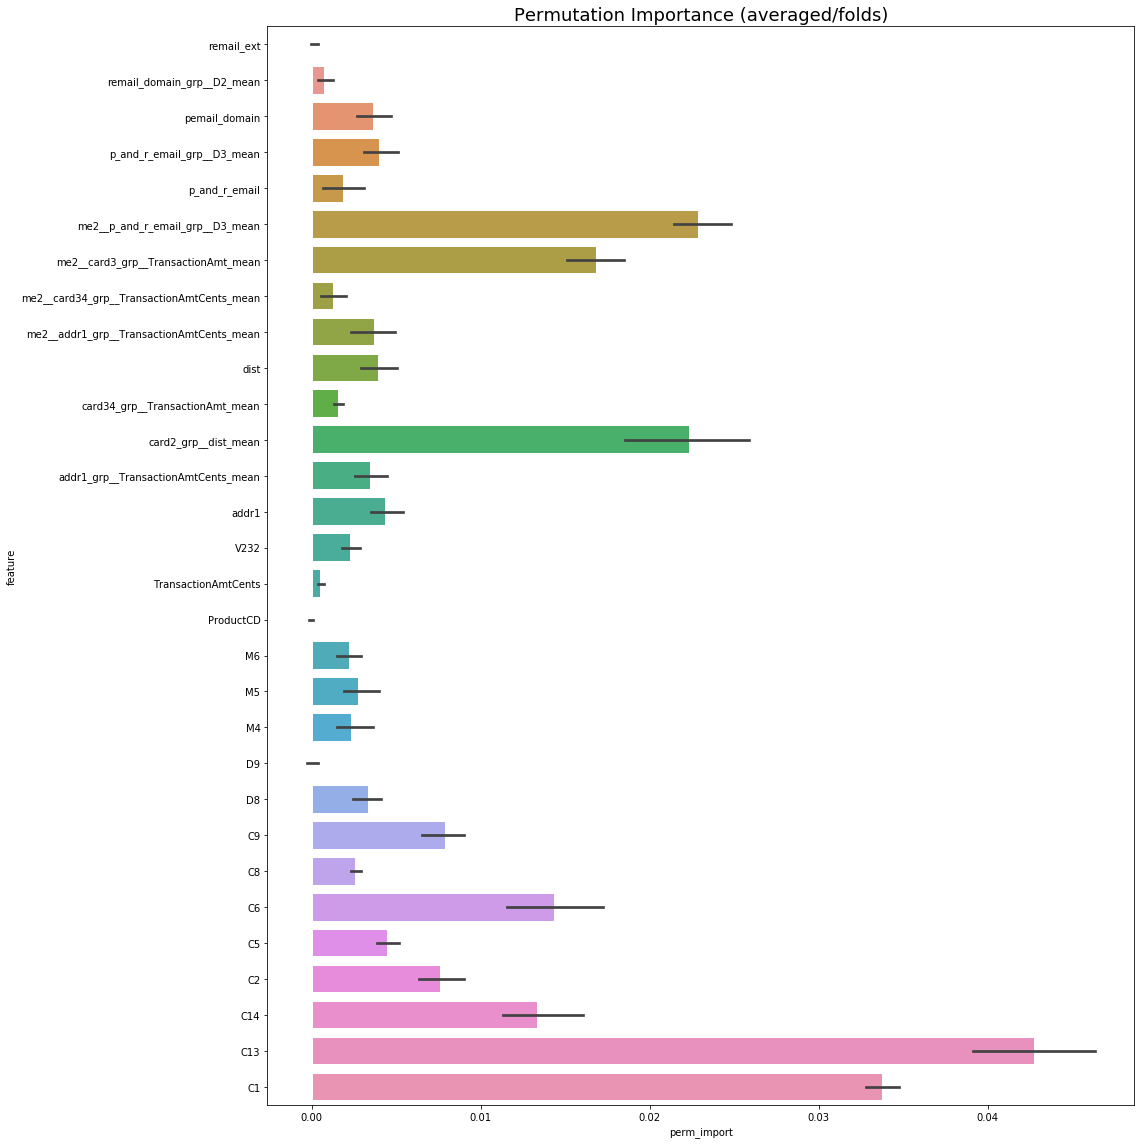

In [126]:
report, sns_features = display_report(results)

plt.figure(figsize=(16, 16))
sns.barplot(x="perm_import", y="feature", data=sns_features, edgecolor=('white'), linewidth=2)#, palette="rocket")
plt.title('Permutation Importance (averaged/folds)', fontsize=18)
plt.tight_layout()

report

If we were to look at regular gain or splits, the V columns would dominate the show. But here we accurately see they really aren't that important in the grand scheme of things. Notice how some of our variables have a very high CVS score, especially the high cardinality categorical variables, like `card2` for example. While the unique values present for card2 in train and test are very similar, their distributions shift a bit:

# TODO: Submission

Once we've decided on a subset of good engineered features to use, we must run the submission pipeline to submit. The submission pipeline is completely different from the feature validation pipeline. Rather, the sub pipeline builds many versions of a single model and merges them together. I wouldn't call this ensembling per se, since that'll happen is another, external script. But this is how we prepare our 'level-1' models for posting against Kaggle LB.

## VersionA

- Train on first 50% of Train data
- Validate on second 50% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on second 50% of Train data using the `mean best rounds` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 2x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 50% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on second 50% of train data, each with the same `mean best rounds`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 2`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), and the mean val of C)
- Try two merging strategies for final LB submission:
    - A^0.2 + B^0.2 + C^0.6, and validate LB
    - (A + B + C) / 3, and validate LB
- Use whichever of the last two strategies works best.

## VersionB

- Train on first 33% of Train data
- Validate on second 33% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Train on second 33% of Train data
- Validate on third 33% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on third 33% of Train data using the `mean best rounds` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 3x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 33% of train data, each with unique `best rounds`.
    - C) 3 models (different seeds) trained on second 33% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on third 33% of train data, each with the same `mean best rounds`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 3`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), the mean val of C), and the mean val of D)
- Try two merging strategies for final LB submission:
    - A^0.166 + B^0.166 + C^0.166 + D^0.6, and validate LB
    - (A + B + C + D) / 4, and validate LB
- Use whichever of the last two strategies works best.

## VersionC

- Train on first 75% of Train data
- Validate on second 25% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on remaining 25% of Train data using the `mean best rounds / 3` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 1.333x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 75% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on second 25% of train data, each with the same `mean best rounds / 3`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 1.333`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), and the mean val of C)
- Try two merging strategies for final LB submission:
    - A^0.2 + B^0.2 + C^0.6, and validate LB
    - (A + B + C) / 3, and validate LB
- Use whichever of the last two strategies works best.

**NOTES**

1. Ideally, the best rounds for the 100% training across these versions should be the sameish.
1. Once we know if geometric or arithmetic mean works best, repeat the above process 5x times, each time using a different 20% (no replacement) non-fraud negative downsampling and straight average results.

In [129]:
def update_seeds(params, new_seed=1337):
    params['seed'] = new_seed
    params['feature_fraction_seed'] = new_seed + 3
    params['bagging_seed'] = new_seed + 5
    params['drop_seed'] = new_seed + 7
    params['data_random_seed'] = new_seed + 11
    return params

In [ ]:
def build_model(data, features, params, mask_train=None, mask_val=None, num_rounds=None, cat_features=None):
    if mask_train is None:
        trn = data[mask_train]
    else:
        trn = data
    trn_lgb = lgb.Dataset(trn[features], label=trn.isFraud)
    
    if mask_val is not None:
        val_lgb = lgb.Dataset(val[features], label=val.isFraud)
        val = data[mask_val]
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 33,
            num_boost_round = 80000,
            categorical_feature = cat_features
        )
        num_rounds = clf.best_score['valid_1']['auc']
        
    else:
        clf = lgb.train(
            params,
            trn_lgb,
            verbose_eval = 200,
            num_boost_round = num_rounds,
            categorical_feature = cat_features
        )
        num_rounds = None
        
    return clf, num_rounds

In [148]:
def prepare_base_submission(data, sub_data, features, params, version='a', runs=1, seed=1337, cat_features=None):
    # Change runs to 3 for a proper (final) sub
    # Runs can be 1 for a 'faster' sub
    version = version.lower()
    params = params.copy() # dont mess up the original
    train = data[~data.isFraud.isna()]
    print('Training Version:', version, 'with', runs, 'runs.')
    
    folder = './' + str(datetime.datetime.now()).replace('-','').replace(':','').split('.')[0].replace(' ','_') + '_v'+version
    !mkdir folder
    
    # Save our info
    with open(folder + '/info.txt', 'a') as handle:
        handle.write('Training Version:', version, 'with', runs, 'runs.')
        handle.write('Params:\n' + json.dumps(params, ensure_ascii=False, indent=4))
        handle.write('\n\nFeatures: ' + ', '.join(features))
    
    if version=='a':
        ########################################################################
        # Train on first 50% of Train data
        # Validate on second 50% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint = (train.TransactionDT.max() - train.TransactionDT.min()) / 2
        splitA = train.TransactionDT<=splitPoint
        splitB = train.TransactionDT> splitPoint
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('Run {}: {} Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        mean_roundsA = int(roundsA.mean())
        std_roundsA = roundsA.std()
        print('{:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: std/mean is pretty high here...')
            
        # Train on second 50% of Train data using the mean best rounds calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                num_rounds = mean_roundsA,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 2x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = mean_roundsA * 2,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) `runs` models (different seeds) trained on first 50% of train data, each with unique best rounds.
        # B) `runs` models (different seeds) trained on second 50% of train data, each with the same mean best rounds
        # C) `runs` models (different seeds) trained on 100% of train data, each with the same mean best rounds * 2
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), and the mean val of C)
        for split in 'abc':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abc'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.2 + splits[1]**0.2 + splits[2]**0.6).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2]).flatten() # No need to even /3 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
        
        
        
    
    elif version=='b':
        ########################################################################
        # Train on first 33% of Train data
        # Validate on second 33% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint1 = (train.TransactionDT.max() - train.TransactionDT.min()) / 3
        splitPoint2 = (train.TransactionDT.max() - train.TransactionDT.min()) / 3 * 2
        splitA = train.TransactionDT<=splitPoint1
        splitB = (train.TransactionDT>splitPoint1) & (train.TransactionDT<=splitPoint2)
        splitC = train.TransactionDT>splitPoint2
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('RunA {}: {} Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
          
        
        # Train on second 33% of Train data
        # Validate on third 33% of Train data
        # Repeat above two steps 3x, with different random model seeds
        roundsB = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                mask_val = splitC,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsB.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('RunB {}: {} Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        roundsB = np.array(roundsB)
        mean_roundsA = int(roundsA.mean())
        mean_roundsB = int(roundsB.mean())
        std_roundsA = roundsA.std()
        std_roundsB = roundsB.std()
        print('A) {:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        print('B) {:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsB, std_roundsB))
        rounds = np.array(roundsA + roundsB)
        mean_rounds = int(rounds.mean())
        std_rounds = rounds.std()
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: A) std/mean is pretty high here...')
        if std_roundsB/mean_roundsB > 0.333: print('NOTE: B) std/mean is pretty high here...')
        if std_rounds/mean_rounds > 0.333: print('NOTE: *) std/mean is pretty high here...')
        
        
        # Train on third 33% of Train data using the mean best rounds calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitC,
                num_rounds = mean_rounds,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 3x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = mean_rounds * 3,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitd_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitd_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) 3 models (different seeds) trained on first 33% of train data, each with unique best rounds.
        # C) 3 models (different seeds) trained on second 33% of train data, each with unique best rounds.
        # B) 3 models (different seeds) trained on third 33% of train data, each with the same mean best rounds
        # C) 3 models (different seeds) trained on 100% of train data, each with the same mean best rounds * 3
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), the mean val of C), and the mean val of D)
        for split in 'abcd':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abcd'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.1666 + splits[1]**0.1666 + splits[2]**0.1666 + splits[2]**0.4).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2] + split[3]).flatten() # No need to even /4 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
        
        
        
    
    
    else:
        ########################################################################
        # Train on first 75% of Train data
        # Validate on second 25% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint = (train.TransactionDT.max() - train.TransactionDT.min()) / 4 * 3
        splitA = train.TransactionDT<=splitPoint
        splitB = train.TransactionDT> splitPoint
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('Run {}: {} Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        mean_roundsA = int(roundsA.mean())
        std_roundsA = roundsA.std()
        print('{:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: std/mean is pretty high here...')
            
        # Train on second 25% of Train data using the mean best rounds / 3 calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                num_rounds = int(mean_roundsA/3),
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 2x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = int(mean_roundsA * 1.3333),
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) 3 models (different seeds) trained on first 75% of train data, each with unique best rounds.
        # B) 3 models (different seeds) trained on second 25% of train data, each with the same mean best rounds / 3
        # C) 3 models (different seeds) trained on 100% of train data, each with the same mean best rounds * 1.3333
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), and the mean val of C)
        for split in 'abc':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abc'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.2 + splits[1]**0.2 + splits[2]**0.6).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2]).flatten() # No need to even /3 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
    
    
    return folder

In [151]:
# TODO (1-time only):
# Run version a locally with runs=3
# Check on Val and LB which is better, geomean or arimean
# Comment out the code for the one that is worse.

# TODO (1-time only())
# Run version a, b, and c locally with runs=3
# Compare a) numrounds*2, b) numrounds*3, c) numrounds*1.333
# Hopefully the values aren't too different
# Check on Val and LB of each version, which is better
# Only use that version going forward

# TODO (each LB submission)
# Use np.random.choice w replace=False to chop up train[traintr.isFraud==0] into 20% chunks
# For each 20% chunk of isFraud=0
# - Merge the 20% isFraud=0 with 100% isFraud=1
# - Run the best 'version' locally with runs=3 and whatever is better geo-mean, or arith-mean
# - Check on Val values of each chunk
# Take the mean of all 5 chunk predictions
# Submit for LB score

In [ ]:
# folder = prepare_base_submission(
#     data,
#     sub_data,
#     features,
#     params,
#     version='a',
#     runs=1,
#     seed=1337,
#     cat_features=None
# )

# EDA (Hereafter)